### Import librarys

In [3]:
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

#object serialization
import _pickle as cPickle  #python 3 change
import os  

%matplotlib inline

In [7]:
#enable memory profiler for memory management usage %%memit 
from memory_profiler import memory_usage
%load_ext memory_profiler

#enable garbage collection control
import gc
gc.enable()

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [8]:
#progress tracker
from tqdm import tqdm, tqdm_notebook

Audio file loading control flag

In [9]:
# when set to TRUE, training data get loaded from a saved serialized data object file 
# All audio files data get saved to a serialized object file to save reloading time on training runs 
#
# Note: 
# On first time run, if serialized file doesn't exist, this flag will get overrident 
#
SKIP_AUDIO_RELOAD = False

### Dataset exploration

#### Ordner Struktur aus Kaggle Code

input/train/Train/fold1...

#### Ordner Struktur von mir

data/audio/fold1...

In [10]:
INPUT_PATH = 'data'

In [13]:
INPUT_FILE = INPUT_PATH+'/metadata/UrbanSound8K.csv'
AUDIO_DIR = INPUT_PATH+'/audio'

In [11]:
def load_input_data(pd, filepath):
    # Read Data
    data = pd.read_csv(filepath)
    return data

In [130]:
# show info
input = load_input_data(pd, INPUT_FILE)
input.rename(columns={'class': 'Class'}, inplace=True)
input.head()

,slice_file_name,fsID,start,end,salience,fold,classID,Class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [131]:
from sklearn.model_selection import train_test_split

train_input, test_input = train_test_split(input, train_size=0.6224)

In [133]:
# labels
valid_train_label = train_input[['Class']]
valid_train_label.count()

# unique classes
x = train_input.groupby('Class')['Class'].count()
x

Class
air_conditioner     612
car_horn            261
children_playing    629
dog_bark            645
drilling            615
engine_idling       605
gun_shot            224
jackhammer          619
siren               598
street_music        626
Name: Class, dtype: int64

In [150]:
valid_train_data = train_input[['slice_file_name', 'fold', 'classID', 'Class']]
valid_train_data.reset_index(drop=True)     # solange das df später nicht per Index angesprochen wird, macht das keine Probleme

,slice_file_name,fold,classID,Class
0,135544-6-14-0.wav,6,6,gun_shot
1,118496-1-0-0.wav,3,1,car_horn
2,54914-2-0-26.wav,8,2,children_playing
3,117048-3-0-23.wav,3,3,dog_bark
4,175849-1-0-0.wav,5,1,car_horn
...,...,...,...,...
5429,102857-5-0-11.wav,10,5,engine_idling
5430,177726-0-0-37.wav,8,0,air_conditioner
5431,146186-5-0-8.wav,1,5,engine_idling
5432,111671-8-0-16.wav,5,8,siren


In [136]:
valid_test_data = test_input[['slice_file_name', 'fold', 'classID']]
valid_test_data.reset_index(drop=True)  # sollte auch keine Probleme machen
valid_test_data.count()

slice_file_name    3298
fold               3298
classID            3298
dtype: int64

### Check input audio file samples

In [138]:
# Siren has iconic spectrogram
train_input[train_input['Class']=='siren'].head()

,slice_file_name,fsID,start,end,salience,fold,classID,Class
7819,74726-8-0-14.wav,74726,7.523561,11.523561,2,6,8,siren
5634,22601-8-0-51.wav,22601,25.500000,29.500000,2,3,8,siren
156,102871-8-0-1.wav,102871,0.500000,4.500000,1,2,8,siren
2034,148632-8-0-4.wav,148632,131.795722,135.795722,2,8,8,siren
5762,24347-8-0-17.wav,24347,12.620371,16.620371,2,4,8,siren


In [139]:
# sample-1 load -> SIREN
sample1_name = '159742-8-0-8.wav'
sample1 = AUDIO_DIR + '/fold' + str(train_input.loc[train_input['slice_file_name']==sample1_name, 'fold'].iloc[0]) + '/' + str(train_input.loc[train_input['slice_file_name']==sample1_name, 'slice_file_name'].iloc[0])
print(sample1)
duration = 2.97
sr = 22050

y, sr = librosa.load(sample1, duration=duration, sr=sr)
ps = librosa.feature.melspectrogram(y=y, sr=sr)

input_length = sr * duration
offset = len(y) - round(input_length)
print('input:', round(input_length), ' load:', len(y), ' offset:', offset)
print('y shape:', y.shape, ' melspec shape:', ps.shape)

data/audio/fold10/159742-8-0-8.wav
input: 65489  load: 65489  offset: 0
y shape: (65489,)  melspec shape: (128, 128)


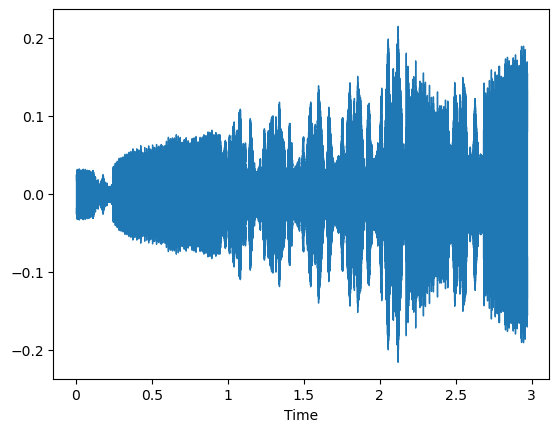

In [140]:
# sample-1 waveplot
librosa.display.waveshow(y) # waveplot gibt es nicht mehr obwohl selbe librose version warum?

In [141]:
# sample-1: audio
import IPython.display as ipd
ipd.Audio(sample1)

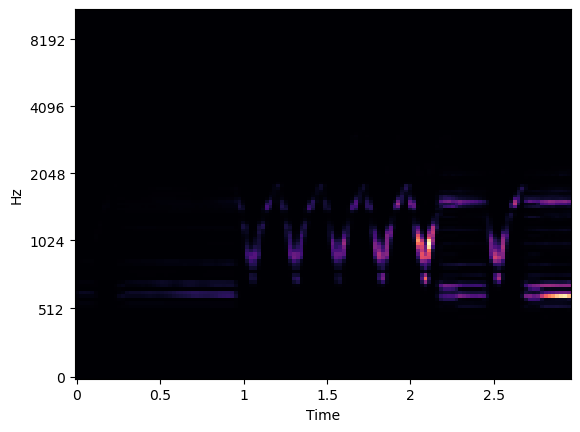

In [142]:
# sample-1: spectrogram
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [144]:
# street_music
train_input[train_input['Class']=='street_music'].head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,Class
6439,42953-9-0-37.wav,42953,18.500000,22.500000,1,9,9,street_music
2217,155202-9-0-42.wav,155202,21.000000,25.000000,1,1,9,street_music
1572,138017-9-1-6.wav,138017,26.393576,30.393576,2,10,9,street_music
3533,172338-9-0-6.wav,172338,91.260480,95.260480,1,4,9,street_music
1605,139951-9-0-33.wav,139951,16.500000,20.500000,1,1,9,street_music
2258,155241-9-0-8.wav,155241,25.291549,29.291549,1,10,9,street_music
6450,42955-9-0-18.wav,42955,9.000000,13.000000,1,6,9,street_music
5072,196384-9-0-2.wav,196384,1.000000,5.000000,1,2,9,street_music
7698,7390-9-0-0.wav,7390,0.000000,4.000000,2,8,9,street_music
3454,171243-9-0-11.wav,171243,5.500000,9.500000,2,8,9,street_music


In [145]:
# sample-2 load -> STREET_MUSIC
sample2_name = '61789-9-0-69.wav'
sample2 = AUDIO_DIR + '/fold' + str(train_input.loc[train_input['slice_file_name']==sample2_name, 'fold'].iloc[0]) + '/' + str(train_input.loc[train_input['slice_file_name']==sample2_name, 'slice_file_name'].iloc[0])
print(sample2)
duration = 2.97
sr = 22050

y2, sr2 = librosa.load(sample2, duration=duration, sr=sr)
ps2 = librosa.feature.melspectrogram(y=y2, sr=sr2)

input_length = sr * duration
offset = len(y2) - round(input_length)
print('input:', round(input_length), ' load:', len(y2), ' offset:', offset)
print('y shape:', y.shape, ' melspec shape:', ps.shape)

data/audio/fold7/61789-9-0-69.wav
input: 65489  load: 65489  offset: 0
y shape: (65489,)  melspec shape: (128, 128)


In [146]:
# sample-2: audio
ipd.Audio(sample2)

(128, 128)

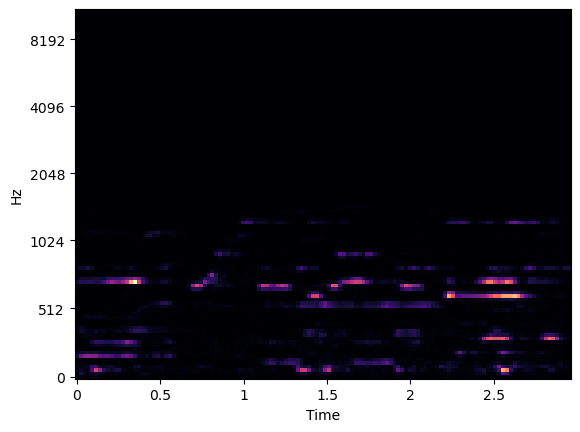

In [147]:
# sample-2: spectrogram
librosa.display.specshow(ps2, y_axis='mel', x_axis='time')
ps.shape

### Prepare data file loading

In [151]:
valid_train_data['path'] = AUDIO_DIR + '/fold' + valid_train_data['fold'].astype(str) + '/' + valid_train_data['slice_file_name'].astype(str)
print('sample', valid_train_data.iloc[0]['path'])
valid_train_data.head()

sample data/audio/fold6/135544-6-14-0.wav


,slice_file_name,fold,classID,Class,path
1480,135544-6-14-0.wav,6,6,gun_shot,data/audio/fold6/135544-6-14-0.wav
919,118496-1-0-0.wav,3,1,car_horn,data/audio/fold3/118496-1-0-0.wav
6779,54914-2-0-26.wav,8,2,children_playing,data/audio/fold8/54914-2-0-26.wav
842,117048-3-0-23.wav,3,3,dog_bark,data/audio/fold3/117048-3-0-23.wav
3706,175849-1-0-0.wav,5,1,car_horn,data/audio/fold5/175849-1-0-0.wav


In [152]:
# test audio files
valid_test_data['path'] = AUDIO_DIR + '/fold' + valid_test_data['fold'].astype(str) + '/' + valid_test_data['slice_file_name'].astype(str)
print('sample', valid_test_data.iloc[0]['path'])
valid_test_data.head()

sample data/audio/fold9/42371-3-0-0.wav


,slice_file_name,fold,classID,path
6432,42371-3-0-0.wav,9,3,data/audio/fold9/42371-3-0-0.wav
6717,54067-2-0-70.wav,3,2,data/audio/fold3/54067-2-0-70.wav
1728,144068-5-0-4.wav,3,5,data/audio/fold3/144068-5-0-4.wav
2608,159708-6-6-0.wav,7,6,data/audio/fold7/159708-6-6-0.wav
7304,68080-7-0-2.wav,8,7,data/audio/fold8/68080-7-0-2.wav


### Loading audio files and features

In [157]:
#
# set duration on audio loading to make audio content to ensure each training data have same size
# 
# for instance, 3 seconds audio will have 128*128 which will be use on this notebook
#
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

#fix the load audio file size
audio_play_duration=2.97

def load_audio_file(file_path, duration=2.97, sr=22050):
    #load 5 seconds audio file, default 22 KHz default sr=22050
    # sr=resample to 16 KHz = 11025
    # sr=resample to 11 KHz = 16000
    # To preserve the native sampling rate of the file, use sr=None
    input_length=sr*duration
    # Load an audio file as a floating point time series.
    # y : np.ndarray [shape=(n,) or (2, n)] - audio time series
    # sr : number > 0 [scalar] - sampling rate of y
    y, sr = librosa.load(file_path,sr=sr, duration=duration)
    dur = librosa.get_duration(y=y)
    #pad output if audio file less than duration
    # Use edge-padding instead of zeros
    #librosa.util.fix_length(y, 10, mode='edge')
    
    # if (round(dur) < duration):
    #     offset = len(y) - round(input_length)
    #     print ("fixing audio length :", file_path)
    #     print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
    #     y = librosa.util.fix_length(y, size=round(input_length))
    
    if (round(dur) < duration):
        print ("fixing audio length :", file_path)
        y = librosa.util.fix_length(y, size=round(input_length))
        offset = len(y) - round(input_length)
        print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
    # y = audio_norm(y)
    # using a pre-computed power spectrogram
    # Short-time Fourier transform (STFT)
    #D = np.abs(librosa.stft(y))**2
    #ps = librosa.feature.melspectrogram(S=D)    
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    return ps

Load audio files

In [158]:
%%time
%%memit 
# Dataset
train_audio_data = [] 
train_object_file='saved_train_audio_data.p'

#override the reload flag if serized file doesn't exist
if not os.path.isfile(train_object_file):
    SKIP_AUDIO_RELOAD = False

#load training data
if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TRAINING data from audio files")
else:
    print ("loading train audio data, may take more than 15 minutes. please wait!")
    for row in tqdm(valid_train_data.itertuples()):
        ps = load_audio_file(file_path=row.path, duration=2.97)
        if ps.shape != (128, 128): continue
        train_audio_data.append( (ps, row.Class) ) 
    print("Number of train samples: ", len(train_audio_data))
# this step took sometime to finish    5382
#peak memory: 1141.30 MiB, increment: 642.16 MiB
#CPU times: user 15min 41s, sys: 14min 57s, total: 30min 39s

loading train audio data, may take more than 15 minutes. please wait!


13it [00:00, 127.71it/s]

fixing audio length : data/audio/fold6/135544-6-14-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/118496-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/175849-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/179868-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/33849-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/159709-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/162434-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-11-0.wav
input: 65489  load: 65489  offset: 0


59it [00:00, 144.88it/s]

fixing audio length : data/audio/fold6/162434-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-14-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/23218-5-0-0.wav
input: 65489  load: 65489  offset: 0


104it [00:00, 145.25it/s]

fixing audio length : data/audio/fold8/83465-1-0-0.wav
input: 65489  load: 65489  offset: 0


134it [00:00, 136.80it/s]

fixing audio length : data/audio/fold10/181624-4-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/143115-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/24965-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/200460-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/102103-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-74-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/88121-8-2-0.wav
input: 65489  load: 65489  offset: 0


165it [00:01, 138.32it/s]

fixing audio length : data/audio/fold2/145608-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/46391-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/160094-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145206-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/50614-3-0-0.wav
input: 65489  load: 65489  offset: 0


210it [00:01, 142.31it/s]

fixing audio length : data/audio/fold7/148827-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/43802-1-2-0.wav
input: 65489  load: 65489  offset: 0


245it [00:01, 156.46it/s]

fixing audio length : data/audio/fold2/4201-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76091-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/24632-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/72723-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/71080-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/35629-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/19503-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/155130-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/83488-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/71309-1-1-0.wav
input: 65489  load: 65489

304it [00:02, 136.32it/s]

fixing audio length : data/audio/fold7/85662-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/147764-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/188823-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-14-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157800-6-0-0.wav
input: 65489  load: 65489  offset: 0


333it [00:02, 134.70it/s]

fixing audio length : data/audio/fold8/189846-3-1-0.wav
input: 65489  load: 65489  offset: 0


361it [00:02, 129.84it/s]

fixing audio length : data/audio/fold7/89210-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/39532-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/43802-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-0-0.wav
input: 65489  load: 65489  offset: 0


390it [00:02, 135.08it/s]

fixing audio length : data/audio/fold4/7064-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/37236-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159702-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-62-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/148828-6-1-0.wav
input: 65489  load: 65489  offset: 0


435it [00:03, 141.21it/s]

fixing audio length : data/audio/fold5/165774-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/175848-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/147672-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/189846-3-0-0.wav
input: 65489  load: 65489  offset: 0


466it [00:03, 141.67it/s]

fixing audio length : data/audio/fold10/34050-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7913-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145612-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/159176-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-25-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/61077-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-5-0.wav
input: 65489  load: 65489  offset: 0


497it [00:03, 145.40it/s]

fixing audio length : data/audio/fold1/86278-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/165567-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/163459-3-0-0.wav
input: 65489  load: 65489  offset: 0


527it [00:03, 136.67it/s]

fixing audio length : data/audio/fold4/156868-8-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/103074-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84254-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/156091-1-0-0.wav
input: 65489  load: 65489  offset: 0


576it [00:04, 149.32it/s]

fixing audio length : data/audio/fold2/132073-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/68657-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/136399-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/155320-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/196061-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/29932-1-1-0.wav
input: 65489  load: 65489  offset: 0


622it [00:04, 138.53it/s]

fixing audio length : data/audio/fold5/162432-6-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/145683-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/161010-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/155234-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/34708-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/89212-3-0-0.wav
input: 65489  load: 65489  offset: 0


670it [00:04, 143.71it/s]

fixing audio length : data/audio/fold4/47926-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159703-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/54086-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/145608-6-2-0.wav
input: 65489  load: 65489  offset: 0


700it [00:04, 138.81it/s]

fixing audio length : data/audio/fold10/7062-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/97756-3-0-0.wav
input: 65489  load: 65489  offset: 0


744it [00:05, 141.51it/s]

fixing audio length : data/audio/fold2/156893-7-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/175843-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/43787-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/167750-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-12-0.wav
input: 65489  load: 65489  offset: 0


774it [00:05, 144.31it/s]

fixing audio length : data/audio/fold4/30832-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148834-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/144028-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/85664-3-0-0.wav
input: 65489  load: 65489  offset: 0


822it [00:05, 154.67it/s]

fixing audio length : data/audio/fold1/9031-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/164667-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/151877-5-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/12647-3-2-0.wav
input: 65489  load: 65489  offset: 0


854it [00:06, 154.21it/s]

fixing audio length : data/audio/fold5/159754-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/151359-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/200460-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/4918-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/77247-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-20-0.wav
input: 65489  load: 65489  offset: 0


906it [00:06, 157.36it/s]

fixing audio length : data/audio/fold5/118440-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-19-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-27-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-77-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/83488-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/128030-3-2-0.wav
input: 65489  load: 65489  offset: 0


939it [00:06, 149.77it/s]

fixing audio length : data/audio/fold1/174276-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/115537-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/14468-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/175855-1-0-0.wav
input: 65489  load: 65489  offset: 0


972it [00:06, 151.66it/s]

fixing audio length : data/audio/fold9/110389-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/33641-3-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/51022-3-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/24965-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-28-0.wav
input: 65489  load: 65489  offset: 0


1004it [00:06, 150.36it/s]

fixing audio length : data/audio/fold3/175847-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/145611-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/191449-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-2-0.wav
input: 65489  load: 65489  offset: 0


1052it [00:07, 150.99it/s]

fixing audio length : data/audio/fold1/43786-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/155129-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197073-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/43805-8-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/174287-6-1-0.wav
input: 65489  load: 65489  offset: 0


1084it [00:07, 144.84it/s]

fixing audio length : data/audio/fold3/207124-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/145683-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/145608-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/162431-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/17913-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/155129-1-0-0.wav
input: 65489  load: 65489  offset: 0


1133it [00:07, 148.68it/s]

fixing audio length : data/audio/fold5/85663-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/110134-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/109711-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/147764-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-64-0.wav
input: 65489  load: 65489  offset: 0


1163it [00:08, 142.80it/s]

fixing audio length : data/audio/fold9/148166-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/146244-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/164312-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7913-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145206-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/20841-3-3-0.wav
input: 65489  load: 65489  offset: 0


1213it [00:08, 148.21it/s]

fixing audio length : data/audio/fold8/125520-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/161195-6-0-0.wav
input: 65489  load: 65489  offset: 0


1244it [00:08, 149.73it/s]

fixing audio length : data/audio/fold5/52102-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/71079-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/33340-7-14-0.wav
input: 65489  load: 65489  offset: 0


1276it [00:08, 149.89it/s]

fixing audio length : data/audio/fold3/34708-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/207962-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159702-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/148841-6-2-0.wav
input: 65489  load: 65489  offset: 0


1309it [00:09, 153.76it/s]

fixing audio length : data/audio/fold5/145611-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/32417-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/148837-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-7-0.wav
input: 65489  load: 65489  offset: 0


1339it [00:09, 129.51it/s]

fixing audio length : data/audio/fold9/152588-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/199929-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/69598-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159701-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/203355-3-0-0.wav
input: 65489  load: 65489  offset: 0


1366it [00:09, 126.97it/s]

fixing audio length : data/audio/fold2/46655-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/27068-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/161010-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/33340-7-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/71087-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/115411-3-0-0.wav
input: 65489  load: 65489  offset: 0


1397it [00:09, 135.90it/s]

fixing audio length : data/audio/fold5/66587-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/200460-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/9031-3-3-0.wav
input: 65489  load: 65489  offset: 0


1445it [00:10, 147.83it/s]

fixing audio length : data/audio/fold2/23131-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/57553-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/187920-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/61077-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/162434-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/30832-3-7-0.wav
input: 65489  load: 65489  offset: 0


1476it [00:10, 139.74it/s]

fixing audio length : data/audio/fold1/77246-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-27-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/98859-7-1-0.wav
input: 65489  load: 65489  offset: 0


1509it [00:10, 150.63it/s]

fixing audio length : data/audio/fold2/34621-4-22-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/107842-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/162728-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/24076-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/145611-6-4-0.wav
input: 65489  load: 65489  offset: 0


1558it [00:10, 153.69it/s]

fixing audio length : data/audio/fold3/95562-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/344-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/162134-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171249-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-72-0.wav
input: 65489  load: 65489  offset: 0


1591it [00:11, 154.87it/s]

fixing audio length : data/audio/fold2/34621-4-17-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/31840-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/12647-3-0-0.wav
input: 65489  load: 65489  offset: 0


1672it [00:11, 153.29it/s]

fixing audio length : data/audio/fold7/85362-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/76094-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7965-3-16-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/171464-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/166268-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/209672-3-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-5-0.wav
input: 65489  load: 65489  offset: 0


1704it [00:11, 156.29it/s]

fixing audio length : data/audio/fold8/17810-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/160575-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/182474-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/194753-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/162540-1-0-0.wav
input: 65489  load: 65489  offset: 0


1737it [00:11, 156.95it/s]

fixing audio length : data/audio/fold6/64346-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/107190-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-8-0.wav
input: 65489  load: 65489  offset: 0


1769it [00:12, 153.74it/s]

fixing audio length : data/audio/fold8/162433-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/85362-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-3-0.wav
input: 65489  load: 65489  offset: 0


1817it [00:12, 150.74it/s]

fixing audio length : data/audio/fold6/204919-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159701-6-4-0.wav
input: 65489  load: 65489  offset: 0


1849it [00:12, 151.24it/s]

fixing audio length : data/audio/fold7/77751-7-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/187356-1-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/107842-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/196064-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/68389-3-2-0.wav
input: 65489  load: 65489  offset: 0


1881it [00:12, 153.80it/s]

fixing audio length : data/audio/fold4/135528-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/176638-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/24965-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/4201-3-1-0.wav
input: 65489  load: 65489  offset: 0


1914it [00:13, 156.75it/s]

fixing audio length : data/audio/fold2/73623-7-5-0.wav
input: 65489  load: 65489  offset: 0


1946it [00:13, 144.61it/s]

fixing audio length : data/audio/fold1/46656-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/165785-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/39533-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/125520-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/128030-3-1-0.wav
input: 65489  load: 65489  offset: 0


1962it [00:13, 146.73it/s]

fixing audio length : data/audio/fold6/28284-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/26185-1-1-0.wav
input: 65489  load: 65489  offset: 0


2010it [00:13, 132.60it/s]

fixing audio length : data/audio/fold2/176634-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/46656-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/156868-8-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/196086-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/115535-3-0-0.wav
input: 65489  load: 65489  offset: 0


2043it [00:14, 144.99it/s]

fixing audio length : data/audio/fold9/136399-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/88466-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/24652-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/7068-6-0-0.wav
input: 65489  load: 65489  offset: 0


2077it [00:14, 154.13it/s]

fixing audio length : data/audio/fold2/203128-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-5-0.wav
input: 65489  load: 65489  offset: 0


2109it [00:14, 152.11it/s]

fixing audio length : data/audio/fold4/68389-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/94710-5-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/9032-3-0-0.wav
input: 65489  load: 65489  offset: 0


2157it [00:14, 151.26it/s]

fixing audio length : data/audio/fold2/156893-7-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/33340-7-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/29932-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/162435-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/145683-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/132073-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/118963-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/35296-3-1-0.wav
input: 65489  lo

2189it [00:15, 151.11it/s]

fixing audio length : data/audio/fold6/179860-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-69-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/121888-3-0-0.wav
input: 65489  load: 65489  offset: 0


2221it [00:15, 150.19it/s]

fixing audio length : data/audio/fold10/7913-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-16-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-14-0.wav
input: 65489  load: 65489  offset: 0


2254it [00:15, 151.35it/s]

fixing audio length : data/audio/fold2/108187-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/26185-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-15-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/113160-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/47926-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/26255-3-8-0.wav
input: 65489  load: 65489  offset: 0


2287it [00:15, 153.55it/s]

fixing audio length : data/audio/fold2/155129-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/145611-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/156868-8-0-0.wav
input: 65489  load: 65489  offset: 0


2319it [00:15, 151.40it/s]

fixing audio length : data/audio/fold3/20841-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/24728-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/7064-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/148841-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/174289-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/66587-3-3-0.wav
input: 65489  load: 65489  offset: 0


2352it [00:16, 140.73it/s]

fixing audio length : data/audio/fold9/180029-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/43787-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/162541-1-0-0.wav
input: 65489  load: 65489  offset: 0


2399it [00:16, 150.06it/s]

fixing audio length : data/audio/fold1/76093-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/57323-8-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/25037-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-6-0.wav
input: 65489  load: 65489  offset: 0


2450it [00:16, 159.19it/s]

fixing audio length : data/audio/fold5/131199-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148835-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/9031-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/183894-1-5-0.wav
input: 65489  load: 65489  offset: 0


2482it [00:16, 152.56it/s]

fixing audio length : data/audio/fold10/169261-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/39532-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-92-0.wav
input: 65489  load: 65489  offset: 0


2530it [00:17, 153.44it/s]

fixing audio length : data/audio/fold8/98536-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/136399-6-8-0.wav
input: 65489  load: 65489  offset: 0


2563it [00:17, 154.76it/s]

fixing audio length : data/audio/fold2/76091-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/194753-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84699-4-3-0.wav
input: 65489  load: 65489  offset: 0


2596it [00:17, 155.15it/s]

fixing audio length : data/audio/fold6/4910-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/159726-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/119420-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-71-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/175856-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/44831-3-1-0.wav
input: 65489  load: 65489  offset: 0


2647it [00:18, 160.84it/s]

fixing audio length : data/audio/fold10/208652-8-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/143604-5-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/203128-3-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/162435-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/49809-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/20285-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/43805-8-2-0.wav
input: 65489  load: 65489  offset: 0


2680it [00:18, 157.08it/s]

fixing audio length : data/audio/fold2/73623-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/117536-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/24631-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/19338-5-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71086-4-2-0.wav
input: 65489  load: 65489  offset: 0


2716it [00:18, 161.95it/s]

fixing audio length : data/audio/fold5/118440-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/85544-3-7-0.wav
input: 65489  load: 65489  offset: 0


2750it [00:18, 160.84it/s]

fixing audio length : data/audio/fold2/22347-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/156194-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/207369-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/42101-1-1-0.wav
input: 65489  load: 65489  offset: 0


2783it [00:18, 150.51it/s]

fixing audio length : data/audio/fold10/100648-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/165645-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/7066-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/164626-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/151065-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/164646-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/9032-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/170243-1-0-0.wav
input: 65489  load: 65489  offset: 0


2817it [00:19, 159.29it/s]

fixing audio length : data/audio/fold7/178115-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/148828-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/165775-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/34643-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/4918-3-4-0.wav
input: 65489  load: 65489  offset: 0


2869it [00:19, 161.06it/s]

fixing audio length : data/audio/fold2/34621-4-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/175845-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-10-0.wav
input: 65489  load: 65489  offset: 0


2902it [00:19, 155.29it/s]

fixing audio length : data/audio/fold3/103199-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/167750-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/65472-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-21-0.wav
input: 65489  load: 65489  offset: 0


2950it [00:19, 153.19it/s]

fixing audio length : data/audio/fold5/162432-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/106955-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/107090-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/36902-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/42324-4-0-0.wav
input: 65489  load: 65489  offset: 0


2983it [00:20, 155.44it/s]

fixing audio length : data/audio/fold10/181624-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/180960-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/165645-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/87275-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/174293-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/132073-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159701-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/132073-1-6-0.wav
input: 65489  load: 65489  offset: 0


3014it [00:20, 144.15it/s]

fixing audio length : data/audio/fold6/167701-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/33340-7-15-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/87275-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/70098-3-2-0.wav
input: 65489  load: 65489  offset: 0


3029it [00:20, 132.05it/s]

fixing audio length : data/audio/fold7/148827-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/175853-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/29936-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/176638-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/37869-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/174293-6-0-0.wav
input: 65489  load: 65489  offset: 0


3058it [00:20, 136.40it/s]

fixing audio length : data/audio/fold9/16772-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/140824-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/175851-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71439-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/17486-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/155309-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/158977-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/159748-8-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/72265-3-4-0.wav
input: 65489  load: 65489  offset: 0


3086it [00:20, 137.28it/s]

fixing audio length : data/audio/fold2/180126-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/39533-4-0-0.wav
input: 65489  load: 65489  offset: 0


3129it [00:21, 127.39it/s]

fixing audio length : data/audio/fold10/54086-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-4-0.wav
input: 65489  load: 65489  offset: 0


3157it [00:21, 115.27it/s]

fixing audio length : data/audio/fold7/135527-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/89209-3-0-0.wav
input: 65489  load: 65489  offset: 0


3185it [00:21, 124.48it/s]

fixing audio length : data/audio/fold3/148838-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-18-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71439-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/200460-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-86-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/24632-6-0-0.wav
input: 65489  load: 65489  offset: 0


3229it [00:22, 134.81it/s]

fixing audio length : data/audio/fold2/34621-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/178261-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/174289-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/162436-6-0-0.wav
input: 65489  load: 65489  offset: 0


3276it [00:22, 147.00it/s]

fixing audio length : data/audio/fold3/188824-7-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/147764-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71086-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/160575-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/43805-8-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/167750-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-2-0.wav
input: 65489  load: 65489  offset: 0


3306it [00:22, 145.27it/s]

fixing audio length : data/audio/fold3/135526-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/196076-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/19503-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-40-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/70098-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/34708-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84699-4-4-0.wav
input: 65489  load: 65489  offset: 0


3336it [00:22, 144.58it/s]

fixing audio length : data/audio/fold4/161010-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/174841-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/85544-3-5-0.wav
input: 65489  load: 65489  offset: 0


3385it [00:23, 152.71it/s]

fixing audio length : data/audio/fold2/34621-4-16-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/26173-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/68389-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/14115-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/73623-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/18453-3-0-0.wav
input: 65489  load: 65489  offset: 0


3416it [00:23, 142.05it/s]

fixing audio length : data/audio/fold6/135544-6-19-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/159752-8-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/150341-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/164312-3-3-0.wav
input: 65489  load: 65489  offset: 0


3446it [00:23, 138.53it/s]

fixing audio length : data/audio/fold4/38231-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/159710-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/165785-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159704-6-0-0.wav
input: 65489  load: 65489  offset: 0


3492it [00:23, 144.68it/s]

fixing audio length : data/audio/fold8/168037-4-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/165645-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/66587-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159754-8-1-0.wav
input: 65489  load: 65489  offset: 0


3523it [00:24, 136.89it/s]

fixing audio length : data/audio/fold2/108187-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/185800-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/7063-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71439-1-0-0.wav
input: 65489  load: 65489  offset: 0


3555it [00:24, 144.90it/s]

fixing audio length : data/audio/fold10/100648-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/102103-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/157950-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-0-0.wav
input: 65489  load: 65489  offset: 0


3588it [00:24, 153.79it/s]

fixing audio length : data/audio/fold1/165645-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/76093-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/34050-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/94401-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/26255-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/50668-5-2-0.wav
input: 65489  load: 65489  offset: 0


3621it [00:24, 155.20it/s]

fixing audio length : data/audio/fold6/135544-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/145683-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/50618-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-11-0.wav
input: 65489  load: 65489  offset: 0


3653it [00:24, 151.58it/s]

fixing audio length : data/audio/fold1/98223-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/4911-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159702-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/4912-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/170015-3-0-0.wav
input: 65489  load: 65489  offset: 0


3685it [00:25, 149.15it/s]

fixing audio length : data/audio/fold4/22883-7-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/7060-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/108187-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/158978-6-0-0.wav
input: 65489  load: 65489  offset: 0


3730it [00:25, 146.93it/s]

fixing audio length : data/audio/fold7/7060-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-1-0.wav
input: 65489  load: 65489  offset: 0


3762it [00:25, 150.36it/s]

fixing audio length : data/audio/fold4/161010-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/174289-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/165785-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/146249-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/196060-2-0-0.wav
input: 65489  load: 65489  offset: 0


3795it [00:25, 154.99it/s]

fixing audio length : data/audio/fold4/171305-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/175850-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/148827-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/4201-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/7061-6-0-0.wav
input: 65489  load: 65489  offset: 0


3829it [00:26, 159.03it/s]

fixing audio length : data/audio/fold2/127872-0-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/151071-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71171-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/185436-1-1-0.wav
input: 65489  load: 65489  offset: 0


3861it [00:26, 158.06it/s]

fixing audio length : data/audio/fold4/171305-7-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/158979-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/148837-6-2-0.wav
input: 65489  load: 65489  offset: 0


3893it [00:26, 146.60it/s]

fixing audio length : data/audio/fold9/180029-4-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/194753-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-15-0.wav
input: 65489  load: 65489  offset: 0


3924it [00:26, 141.32it/s]

fixing audio length : data/audio/fold3/34708-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/44278-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/165567-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159701-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/148827-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/7060-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/26176-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/85661-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/162431-6-2-0.wav
input: 65489  load: 65489  offset: 0


3970it [00:27, 146.85it/s]

fixing audio length : data/audio/fold8/131571-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84699-4-0-0.wav
input: 65489  load: 65489  offset: 0


4002it [00:27, 150.68it/s]

fixing audio length : data/audio/fold6/159702-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/29936-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/71082-4-1-0.wav
input: 65489  load: 65489  offset: 0


4034it [00:27, 150.68it/s]

fixing audio length : data/audio/fold9/180156-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/186938-5-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/174290-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/20841-3-2-0.wav
input: 65489  load: 65489  offset: 0


4066it [00:27, 149.30it/s]

fixing audio length : data/audio/fold10/205013-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/158607-3-0-0.wav
input: 65489  load: 65489  offset: 0


4116it [00:28, 154.72it/s]

fixing audio length : data/audio/fold5/66587-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/209672-3-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/113785-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/175846-1-0-0.wav
input: 65489  load: 65489  offset: 0


4148it [00:28, 151.77it/s]

fixing audio length : data/audio/fold4/162435-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/150341-3-1-0.wav
input: 65489  load: 65489  offset: 0


4180it [00:28, 144.75it/s]

fixing audio length : data/audio/fold5/26177-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/50668-5-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/94020-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/88121-8-1-0.wav
input: 65489  load: 65489  offset: 0


4214it [00:28, 153.34it/s]

fixing audio length : data/audio/fold6/135544-6-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/17486-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/26177-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/151359-1-0-0.wav
input: 65489  load: 65489  offset: 0


4278it [00:29, 156.13it/s]

fixing audio length : data/audio/fold3/135526-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/125554-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76091-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/20841-3-6-0.wav
input: 65489  load: 65489  offset: 0


4310it [00:29, 151.06it/s]

fixing audio length : data/audio/fold8/113203-5-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-63-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/116163-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/196080-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/179867-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/203355-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-1-0.wav
input: 65489  load: 65489  offset: 0


4359it [00:29, 153.84it/s]

fixing audio length : data/audio/fold6/162702-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/118072-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7913-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148835-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/111048-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/84317-3-0-0.wav
input: 65489  load: 65489  offset: 0


4405it [00:29, 141.50it/s]

fixing audio length : data/audio/fold3/135526-6-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171249-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/176003-1-0-0.wav
input: 65489  load: 65489  offset: 0


4450it [00:30, 144.65it/s]

fixing audio length : data/audio/fold4/22883-7-48-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/96158-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/17074-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/208030-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/76094-6-0-0.wav
input: 65489  load: 65489  offset: 0


4484it [00:30, 153.86it/s]

fixing audio length : data/audio/fold9/155130-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/26255-3-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-6-0.wav
input: 65489  load: 65489  offset: 0


4533it [00:30, 153.12it/s]

fixing audio length : data/audio/fold2/158607-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/147764-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-20-0.wav
input: 65489  load: 65489  offset: 0


4599it [00:31, 150.69it/s]

fixing audio length : data/audio/fold3/90846-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/133797-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/166268-3-1-0.wav
input: 65489  load: 65489  offset: 0


4664it [00:31, 153.36it/s]

fixing audio length : data/audio/fold3/188824-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/100032-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/344-3-1-0.wav
input: 65489  load: 65489  offset: 0


4696it [00:31, 152.84it/s]

fixing audio length : data/audio/fold1/43786-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/87275-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148833-6-0-0.wav
input: 65489  load: 65489  offset: 0


4729it [00:32, 150.48it/s]

fixing audio length : data/audio/fold10/17486-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84699-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/183894-1-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-21-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7965-3-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/162435-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/179862-1-0-0.wav
input: 65489  load: 65489  offset: 0


4763it [00:32, 150.27it/s]

fixing audio length : data/audio/fold8/145612-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-2-0.wav
input: 65489  load: 65489  offset: 0


4794it [00:32, 147.17it/s]

fixing audio length : data/audio/fold4/22883-7-81-0.wav
input: 65489  load: 65489  offset: 0


4826it [00:32, 150.84it/s]

fixing audio length : data/audio/fold1/165645-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/50629-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/151359-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/23161-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/46656-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/147672-3-1-0.wav
input: 65489  load: 65489  offset: 0


4859it [00:32, 148.50it/s]

fixing audio length : data/audio/fold9/178118-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/178118-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/82811-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/33641-3-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/49769-5-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/19026-1-0-0.wav
input: 65489  load: 65489  offset: 0


4906it [00:33, 152.28it/s]

fixing audio length : data/audio/fold5/116163-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159702-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/208652-8-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/17913-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/179866-1-1-0.wav
input: 65489  load: 65489  offset: 0


4938it [00:33, 149.50it/s]

fixing audio length : data/audio/fold1/46656-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/174287-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-0-0.wav
input: 65489  load: 65489  offset: 0


4986it [00:33, 151.07it/s]

fixing audio length : data/audio/fold10/162134-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/89213-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/73623-7-2-0.wav
input: 65489  load: 65489  offset: 0


5034it [00:34, 151.90it/s]

fixing audio length : data/audio/fold1/98223-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/50613-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/204919-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/7064-6-3-0.wav
input: 65489  load: 65489  offset: 0


5069it [00:34, 159.63it/s]

fixing audio length : data/audio/fold7/148827-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/17810-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/26184-5-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/208030-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-100-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/174293-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/87275-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-0-0.wav
input: 65489  load: 65489  offset: 0


5101it [00:34, 154.08it/s]

fixing audio length : data/audio/fold5/159701-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/164312-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/100648-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/125520-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/132073-1-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-12-0.wav
input: 65489  load: 65489  offset: 0


5151it [00:34, 157.56it/s]

fixing audio length : data/audio/fold1/197318-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/87275-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/100648-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/7064-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/25039-6-1-0.wav
input: 65489  load: 65489  offset: 0


5184it [00:35, 158.92it/s]

fixing audio length : data/audio/fold5/185436-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-17-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/97606-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/44278-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/54086-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/24728-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/103076-3-1-0.wav
input: 65489  load: 65489  offset: 0


5218it [00:35, 159.70it/s]

fixing audio length : data/audio/fold3/118496-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-18-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/36902-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/145609-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7965-3-3-0.wav
input: 65489  load: 65489  offset: 0


5266it [00:35, 155.66it/s]

fixing audio length : data/audio/fold7/50612-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-13-0.wav
input: 65489  load: 65489  offset: 0


5298it [00:35, 143.53it/s]

fixing audio length : data/audio/fold9/33641-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/6984-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/26177-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/145683-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159702-6-0-0.wav
input: 65489  load: 65489  offset: 0


5365it [00:36, 160.52it/s]

fixing audio length : data/audio/fold5/45256-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/344-3-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/175842-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/102106-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/89207-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/73168-1-0-0.wav
input: 65489  load: 65489  offset: 0


5416it [00:36, 161.57it/s]

fixing audio length : data/audio/fold1/94868-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/49809-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/147672-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/71309-1-2-0.wav
input: 65489  load: 65489  offset: 0


5434it [00:36, 148.08it/s]

fixing audio length : data/audio/fold10/157207-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/152588-3-2-0.wav
input: 65489  load: 65489  offset: 0
Number of train samples:  5386
peak memory: 384.66 MiB, increment: 77.81 MiB
CPU times: user 45.1 s, sys: 4.91 s, total: 50 s
Wall time: 37.6 s


In [164]:
# load saved audio object
if SKIP_AUDIO_RELOAD is True:
    train_audio_data = cPickle.load(open(train_object_file, 'rb'))
    print ("loaded train data [%s] records from object file" % len(train_audio_data))  
else:
    cPickle.dump(train_audio_data, open(train_object_file, 'wb')) 
    print ("saved loaded train data :",len(train_audio_data))

saved loaded train data : 5386


In [165]:
%%time
%%memit 
#load test data
test_audio_data = []
test_object_file='saved_test_audio_data.p'

#override the reload flag if serized file doesn't exist
if not os.path.isfile(test_object_file):
    SKIP_AUDIO_RELOAD = False

if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TEST data from audio files")
else:
    print ("loading test audio data, may take more than 15 minutes. please wait!")
    for row in tqdm(valid_test_data.itertuples()):
        ps = load_audio_file(file_path=row.path, duration=2.97)
        if ps.shape != (128, 128):
            print ("***data shape is wrong, replace it with zeros ", ps.shape, row.path)
            ps = np.zeros([128, 128])
            #continue
        test_audio_data.append( (ps, row.classID) ) 
    print("Number of train samples: ", len(train_audio_data))
    
# this step took sometime to finish    3251
#peak memory: 1586.96 MiB, increment: 445.65 MiB
#CPU times: user 9min 32s, sys: 9min 37s, total: 19min 10s 

loading test audio data, may take more than 15 minutes. please wait!


10it [00:00, 97.20it/s]

fixing audio length : data/audio/fold9/42371-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/33340-7-5-0.wav
input: 65489  load: 65489  offset: 0


51it [00:00, 128.66it/s]

fixing audio length : data/audio/fold8/50668-5-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/127873-0-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/201207-3-13-0.wav
input: 65489  load: 65489  offset: 0


79it [00:00, 134.44it/s]

fixing audio length : data/audio/fold5/162432-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/158607-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/34241-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-8-0.wav
input: 65489  load: 65489  offset: 0


108it [00:00, 136.89it/s]

fixing audio length : data/audio/fold5/118440-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/46654-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-16-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 113) data/audio/fold4/187356-1-5-0.wav
fixing audio length : data/audio/fold10/2937-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/24965-3-1-0.wav
input: 65489  load: 65489  offset: 0


139it [00:01, 143.02it/s]

fixing audio length : data/audio/fold6/135544-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/179864-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/73168-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-13-0.wav
input: 65489  load: 65489  offset: 0


184it [00:01, 138.65it/s]

fixing audio length : data/audio/fold5/170245-0-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/197243-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159702-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/77751-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-93-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-28-0.wav
input: 65489  load: 65489  offset: 0


214it [00:01, 138.90it/s]

fixing audio length : data/audio/fold8/29936-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/18933-1-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 120) data/audio/fold3/144068-5-2-0.wav
fixing audio length : data/audio/fold5/178260-7-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/164627-1-0-0.wav
input: 65489  load: 65489  offset: 0


244it [00:01, 138.47it/s]

fixing audio length : data/audio/fold2/34621-4-18-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/116163-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84699-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/159707-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/103076-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-67-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 127) data/audio/fold10/20571-3-0-0.wav
fixing audio length : data/audio/fold1/46656-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-10-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 127) data/audio/fold10/174292-6-0-0.wav


274it [00:02, 142.33it/s]

fixing audio length : data/audio/fold4/171305-7-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/160575-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/201207-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/34708-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/52357-6-0-0.wav
input: 65489  load: 65489  offset: 0


306it [00:02, 149.65it/s]

fixing audio length : data/audio/fold4/22883-7-37-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/157799-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/38231-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76091-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-1-0.wav
input: 65489  load: 65489  offset: 0


338it [00:02, 152.42it/s]

fixing audio length : data/audio/fold3/179863-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135849-4-0-0.wav
input: 65489  load: 65489  offset: 0


403it [00:02, 153.33it/s]

fixing audio length : data/audio/fold8/33340-7-16-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/196071-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/183894-1-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/175856-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/178402-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-5-0.wav
input: 65489  load: 65489  offset: 0


437it [00:03, 158.40it/s]

fixing audio length : data/audio/fold2/203128-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/33641-3-8-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 127) data/audio/fold3/73373-3-0-0.wav
fixing audio length : data/audio/fold4/204765-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/71082-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/185436-1-7-0.wav
input: 65489  load: 65489  offset: 0


469it [00:03, 156.52it/s]

fixing audio length : data/audio/fold3/166101-5-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/26186-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/196062-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-26-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/160575-3-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/151359-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-6-0.wav
input: 65489  load: 65489  offset: 0


501it [00:03, 150.27it/s]

fixing audio length : data/audio/fold6/148835-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/69598-4-4-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 113) data/audio/fold9/174282-6-1-0.wav
fixing audio length : data/audio/fold8/159706-6-0-0.wav
input: 65489  load: 65489  offset: 0


533it [00:03, 150.23it/s]

fixing audio length : data/audio/fold6/148833-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/179866-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/174287-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/34871-3-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/200460-6-2-0.wav
input: 65489  load: 65489  offset: 0


564it [00:03, 134.99it/s]

fixing audio length : data/audio/fold5/145611-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/125520-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/94868-1-2-0.wav
input: 65489  load: 65489  offset: 0


593it [00:04, 118.95it/s]

fixing audio length : data/audio/fold4/171305-7-23-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/24728-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/159745-8-0-0.wav
input: 65489  load: 65489  offset: 0


624it [00:04, 132.71it/s]

***data shape is wrong, replace it with zeros  (128, 121) data/audio/fold10/39847-5-1-0.wav
fixing audio length : data/audio/fold3/12647-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/200161-3-7-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold10/162134-7-4-0.wav


654it [00:04, 136.96it/s]

fixing audio length : data/audio/fold2/118962-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/174276-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/148838-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-6-0.wav
input: 65489  load: 65489  offset: 0


696it [00:04, 133.37it/s]

fixing audio length : data/audio/fold6/135544-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/174290-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/23131-3-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/59800-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-7-0.wav
input: 65489  load: 65489  offset: 0


727it [00:05, 142.55it/s]

***data shape is wrong, replace it with zeros  (128, 118) data/audio/fold9/59037-2-3-0.wav
***data shape is wrong, replace it with zeros  (128, 114) data/audio/fold8/174285-6-1-0.wav
fixing audio length : data/audio/fold5/139948-3-2-0.wav
input: 65489  load: 65489  offset: 0


760it [00:05, 148.04it/s]

fixing audio length : data/audio/fold10/157207-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-7-0.wav
input: 65489  load: 65489  offset: 0


790it [00:05, 146.71it/s]

fixing audio length : data/audio/fold4/7064-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/164625-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/69598-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/162431-6-3-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold3/78776-6-0-0.wav


820it [00:05, 143.00it/s]

fixing audio length : data/audio/fold2/34621-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/143115-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148835-6-3-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 115) data/audio/fold10/188813-7-13-0.wav
fixing audio length : data/audio/fold6/36403-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/165645-4-4-0.wav
input: 65489  load: 65489  offset: 0


852it [00:06, 147.39it/s]

***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold7/99812-1-5-0.wav
fixing audio length : data/audio/fold4/22883-7-9-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 116) data/audio/fold3/135526-6-12-0.wav
fixing audio length : data/audio/fold7/135527-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/189846-3-4-0.wav
input: 65489  load: 65489  offset: 0


886it [00:06, 145.26it/s]

fixing audio length : data/audio/fold1/147764-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-8-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 127) data/audio/fold8/167702-4-9-0.wav
fixing audio length : data/audio/fold3/103199-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold8/103076-3-0-0.wav
fixing audio length : data/audio/fold6/71088-4-2-0.wav
input: 65489  load: 65489  offset: 0


935it [00:06, 153.83it/s]

***data shape is wrong, replace it with zeros  (128, 121) data/audio/fold4/35629-3-0-0.wav
fixing audio length : data/audio/fold5/118440-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-3-0.wav
input: 65489  load: 65489  offset: 0


967it [00:06, 149.06it/s]

fixing audio length : data/audio/fold2/34621-4-25-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/197243-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/37869-3-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/58202-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-6-0.wav
input: 65489  load: 65489  offset: 0


1014it [00:07, 152.06it/s]

fixing audio length : data/audio/fold9/180029-4-20-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/23131-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/34708-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-12-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold9/157801-6-0-0.wav
fixing audio length : data/audio/fold8/196074-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/24728-7-3-0.wav
input: 65489  load: 65489  offset: 0


1045it [00:07, 144.45it/s]

fixing audio length : data/audio/fold9/159726-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/148838-6-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold4/171305-7-26-0.wav
fixing audio length : data/audio/fold5/37869-3-0-0.wav
input: 65489  load: 65489  offset: 0


1092it [00:07, 139.96it/s]

fixing audio length : data/audio/fold6/135544-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/167702-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/52171-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/97606-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/178118-3-1-0.wav
input: 65489  load: 65489  offset: 0


1122it [00:07, 141.90it/s]

fixing audio length : data/audio/fold4/135528-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/25039-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/39857-5-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14524-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-8-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 112) data/audio/fold8/49974-1-0-0.wav


1155it [00:08, 150.42it/s]

fixing audio length : data/audio/fold6/179725-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/33849-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84699-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/113203-5-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/23131-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/7064-6-1-0.wav
input: 65489  load: 65489  offset: 0


1187it [00:08, 148.08it/s]

fixing audio length : data/audio/fold6/135544-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/344-3-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 110) data/audio/fold8/113203-5-2-0.wav
***data shape is wrong, replace it with zeros  (128, 113) data/audio/fold9/136399-6-7-0.wav
fixing audio length : data/audio/fold6/135544-6-17-0.wav
input: 65489  load: 65489  offset: 0


1217it [00:08, 145.27it/s]

fixing audio length : data/audio/fold6/135544-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/118964-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76089-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/203128-3-6-0.wav
input: 65489  load: 65489  offset: 0


1264it [00:08, 151.03it/s]

***data shape is wrong, replace it with zeros  (128, 115) data/audio/fold10/181624-4-2-0.wav
fixing audio length : data/audio/fold2/4201-3-2-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 126) data/audio/fold10/26344-4-0-0.wav
fixing audio length : data/audio/fold9/25038-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/162703-1-0-0.wav
input: 65489  load: 65489  offset: 0


1298it [00:09, 154.80it/s]

***data shape is wrong, replace it with zeros  (128, 120) data/audio/fold3/33696-3-0-0.wav
***data shape is wrong, replace it with zeros  (128, 120) data/audio/fold3/49809-3-3-0.wav
fixing audio length : data/audio/fold3/160093-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/43787-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/165785-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/57553-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/132073-1-1-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 124) data/audio/fold3/207124-3-1-0.wav


1330it [00:09, 151.07it/s]

fixing audio length : data/audio/fold7/43805-8-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159705-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/203956-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/37869-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/34050-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/128030-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-4-0.wav
input: 65489  load: 65489  offset: 0


1365it [00:09, 158.47it/s]

fixing audio length : data/audio/fold4/22883-7-33-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/35799-6-0-0.wav
input: 65489  load: 65489  offset: 0


1413it [00:09, 150.63it/s]

fixing audio length : data/audio/fold8/167702-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-0-0.wav
input: 65489  load: 65489  offset: 0


1445it [00:09, 152.32it/s]

fixing audio length : data/audio/fold7/159708-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/145577-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/44110-3-1-0.wav
input: 65489  load: 65489  offset: 0


1493it [00:10, 154.51it/s]

fixing audio length : data/audio/fold3/118070-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/54858-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/118961-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/175854-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/35296-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/81791-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/57553-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-2-0.wav
input: 65489  load: 65489  offset: 0


1525it [00:10, 148.83it/s]

fixing audio length : data/audio/fold7/34241-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/187356-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/204919-3-4-0.wav
input: 65489  load: 65489  offset: 0


1558it [00:10, 145.00it/s]

fixing audio length : data/audio/fold4/171305-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/162541-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145206-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/86284-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/33340-7-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/160092-3-0-0.wav
input: 65489  load: 65489  offset: 0


1591it [00:10, 152.79it/s]

fixing audio length : data/audio/fold8/175856-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/70098-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/73623-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/165785-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/156418-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/136399-6-4-0.wav
input: 65489  load: 65489  offset: 0


1624it [00:11, 155.97it/s]

fixing audio length : data/audio/fold5/179861-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/23161-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145206-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/194753-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/209672-3-3-0.wav
input: 65489  load: 65489  offset: 0


1656it [00:11, 153.65it/s]

fixing audio length : data/audio/fold2/71080-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/39532-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/174287-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/85665-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/162540-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-2-0.wav
input: 65489  load: 65489  offset: 0


1736it [00:11, 149.90it/s]

fixing audio length : data/audio/fold10/188813-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/174290-6-2-0.wav
input: 65489  load: 65489  offset: 0


1770it [00:12, 154.85it/s]

***data shape is wrong, replace it with zeros  (128, 112) data/audio/fold1/182800-2-1-0.wav
fixing audio length : data/audio/fold5/205874-4-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159754-8-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/42324-4-1-0.wav
input: 65489  load: 65489  offset: 0


1802it [00:12, 150.36it/s]

fixing audio length : data/audio/fold1/9031-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/190680-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/143115-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/196088-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/72567-1-3-0.wav
input: 65489  load: 65489  offset: 0


1851it [00:12, 155.08it/s]

***data shape is wrong, replace it with zeros  (128, 114) data/audio/fold7/174284-6-1-0.wav
fixing audio length : data/audio/fold5/77509-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145612-6-2-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 115) data/audio/fold8/33340-7-2-0.wav
fixing audio length : data/audio/fold6/208030-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/4912-3-1-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 117) data/audio/fold2/197320-6-6-0.wav
fixing audio length : data/audio/fold10/208652-8-4-0.wav
input: 65489  load: 65489  offset: 0


1883it [00:12, 153.98it/s]

fixing audio length : data/audio/fold1/46656-6-4-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 110) data/audio/fold5/185436-1-2-0.wav
fixing audio length : data/audio/fold9/145683-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/162541-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-4-0.wav
input: 65489  load: 65489  offset: 0


1950it [00:13, 156.21it/s]

fixing audio length : data/audio/fold10/174289-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/17307-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/93139-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/96159-4-1-0.wav
input: 65489  load: 65489  offset: 0


1983it [00:13, 157.43it/s]

fixing audio length : data/audio/fold2/33849-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/196078-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/207962-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/39532-4-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 127) data/audio/fold5/196081-2-0-0.wav
fixing audio length : data/audio/fold10/142641-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-5-0.wav
input: 65489  load: 65489  offset: 0


2017it [00:13, 161.30it/s]

fixing audio length : data/audio/fold9/180156-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/113785-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/185436-1-5-0.wav
input: 65489  load: 65489  offset: 0


2067it [00:14, 150.54it/s]

fixing audio length : data/audio/fold3/162431-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/43803-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/187356-1-1-0.wav
input: 65489  load: 65489  offset: 0


2099it [00:14, 148.77it/s]

fixing audio length : data/audio/fold5/165774-7-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/143115-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/209672-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/139948-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/165775-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/125520-1-3-0.wav
input: 65489  load: 65489  offset: 0


2132it [00:14, 154.74it/s]

***data shape is wrong, replace it with zeros  (128, 124) data/audio/fold2/197320-6-4-0.wav
fixing audio length : data/audio/fold7/89679-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/147764-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/151069-6-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 114) data/audio/fold10/26344-4-1-0.wav
fixing audio length : data/audio/fold10/17124-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/51022-3-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/189846-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-29-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/30832-3-12-0.wav
input: 65489  lo

2165it [00:14, 155.33it/s]

fixing audio length : data/audio/fold8/24728-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/11722-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/89211-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-2-0.wav
input: 65489  load: 65489  offset: 0


2197it [00:14, 148.38it/s]

fixing audio length : data/audio/fold9/73168-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/107090-1-0-0.wav
input: 65489  load: 65489  offset: 0


2245it [00:15, 153.07it/s]

fixing audio length : data/audio/fold7/153057-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/176631-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-8-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 120) data/audio/fold2/197320-6-12-0.wav
***data shape is wrong, replace it with zeros  (128, 119) data/audio/fold8/29936-3-0-0.wav
fixing audio length : data/audio/fold5/159701-6-3-0.wav
input: 65489  load: 65489  offset: 0


2277it [00:15, 153.23it/s]

fixing audio length : data/audio/fold9/180156-1-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/200460-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/133797-6-2-0.wav
input: 65489  load: 65489  offset: 0


2327it [00:15, 156.59it/s]

fixing audio length : data/audio/fold5/26184-5-2-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 127) data/audio/fold4/201207-3-21-0.wav
***data shape is wrong, replace it with zeros  (128, 126) data/audio/fold5/62566-5-2-0.wav
fixing audio length : data/audio/fold7/97606-7-3-0.wav
input: 65489  load: 65489  offset: 0


2359it [00:15, 151.09it/s]

fixing audio length : data/audio/fold4/35296-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/57607-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/180132-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/108187-3-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/175852-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-6-0.wav
input: 65489  load: 65489  offset: 0


2393it [00:16, 157.84it/s]

fixing audio length : data/audio/fold2/76090-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/110622-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/155313-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/156362-4-1-0.wav
input: 65489  load: 65489  offset: 0


2425it [00:16, 158.75it/s]

fixing audio length : data/audio/fold2/175844-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/4912-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/148841-6-0-0.wav
input: 65489  load: 65489  offset: 0


2459it [00:16, 162.01it/s]

***data shape is wrong, replace it with zeros  (128, 112) data/audio/fold4/22883-7-83-0.wav
fixing audio length : data/audio/fold8/145206-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/43784-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/162702-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/26184-5-0-0.wav
input: 65489  load: 65489  offset: 0


2509it [00:16, 144.91it/s]

***data shape is wrong, replace it with zeros  (128, 113) data/audio/fold10/34050-7-4-0.wav
fixing audio length : data/audio/fold8/4918-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/171464-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/43784-3-1-0.wav
input: 65489  load: 65489  offset: 0


2542it [00:17, 145.17it/s]

fixing audio length : data/audio/fold7/14772-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/102104-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/196079-2-0-0.wav
input: 65489  load: 65489  offset: 0


2576it [00:17, 155.36it/s]

fixing audio length : data/audio/fold5/71439-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/4918-3-1-0.wav
input: 65489  load: 65489  offset: 0


2608it [00:17, 151.78it/s]

fixing audio length : data/audio/fold2/156893-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76090-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/162148-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/179865-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/99185-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-3-0.wav
input: 65489  load: 65489  offset: 0


2641it [00:17, 154.37it/s]

***data shape is wrong, replace it with zeros  (128, 122) data/audio/fold7/97606-7-2-0.wav
fixing audio length : data/audio/fold6/125574-3-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 110) data/audio/fold9/59037-2-2-0.wav


2676it [00:18, 152.45it/s]

fixing audio length : data/audio/fold1/184355-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-15-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-1-0.wav
input: 65489  load: 65489  offset: 0


2708it [00:18, 151.19it/s]

***data shape is wrong, replace it with zeros  (128, 125) data/audio/fold10/174292-6-1-0.wav
fixing audio length : data/audio/fold5/203516-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/25037-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/87275-1-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84699-4-1-0.wav
input: 65489  load: 65489  offset: 0


2756it [00:18, 149.03it/s]

fixing audio length : data/audio/fold10/34050-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/43802-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/44110-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/133797-6-0-0.wav
input: 65489  load: 65489  offset: 0


2806it [00:18, 156.00it/s]

fixing audio length : data/audio/fold7/14772-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/99812-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/4912-3-3-0.wav
input: 65489  load: 65489  offset: 0


2839it [00:19, 153.02it/s]

***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold2/197320-6-3-0.wav
fixing audio length : data/audio/fold1/94868-1-0-0.wav
input: 65489  load: 65489  offset: 0


2871it [00:19, 153.76it/s]

fixing audio length : data/audio/fold3/144885-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/156868-8-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/166268-3-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 121) data/audio/fold9/196058-2-0-0.wav


2903it [00:19, 152.76it/s]

fixing audio length : data/audio/fold5/145609-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/148837-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/100648-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/47926-3-2-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 118) data/audio/fold7/7067-6-0-0.wav


2935it [00:19, 135.75it/s]

fixing audio length : data/audio/fold8/145612-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148835-6-4-0.wav
input: 65489  load: 65489  offset: 0


2984it [00:20, 147.73it/s]

fixing audio length : data/audio/fold4/171249-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/11722-3-1-0.wav
input: 65489  load: 65489  offset: 0


3014it [00:20, 145.71it/s]

fixing audio length : data/audio/fold9/52171-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/155283-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/33849-3-3-0.wav
input: 65489  load: 65489  offset: 0


3044it [00:20, 146.27it/s]

fixing audio length : data/audio/fold5/159701-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-24-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/9032-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76091-6-2-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 113) data/audio/fold4/171305-7-27-0.wav


3092it [00:20, 153.19it/s]

fixing audio length : data/audio/fold4/22883-7-91-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/51022-3-29-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/71079-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/21187-5-0-0.wav
input: 65489  load: 65489  offset: 0


3125it [00:21, 155.66it/s]

fixing audio length : data/audio/fold5/71171-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/145608-6-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 127) data/audio/fold10/157207-6-0-0.wav
fixing audio length : data/audio/fold5/121299-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197073-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/149177-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-12-0.wav
input: 65489  load: 65489  offset: 0


3157it [00:21, 150.37it/s]

fixing audio length : data/audio/fold8/162433-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/147317-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/89679-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/52284-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/183894-1-6-0.wav
input: 65489  load: 65489  offset: 0


3189it [00:21, 151.51it/s]

fixing audio length : data/audio/fold9/25038-6-1-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 126) data/audio/fold5/178260-7-6-0.wav
fixing audio length : data/audio/fold3/188824-7-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/163460-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/156200-2-0-0.wav
input: 65489  load: 65489  offset: 0


3237it [00:21, 151.66it/s]

fixing audio length : data/audio/fold9/136399-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145206-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/156868-8-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/162540-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-34-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/179858-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/44831-3-2-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold3/103199-4-4-0.wav
fixing audio length : data/audio/fold2/76091-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/132073-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-2-0.wav
input: 65489  loa

3270it [00:21, 157.20it/s]

fixing audio length : data/audio/fold6/70740-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-14-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/43787-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-51-0.wav
input: 65489  load: 65489  offset: 0


3298it [00:22, 148.85it/s]


fixing audio length : data/audio/fold7/207962-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/143115-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-12-0.wav
input: 65489  load: 65489  offset: 0
Number of train samples:  5386
peak memory: 343.66 MiB, increment: 36.61 MiB
CPU times: user 27.4 s, sys: 3.09 s, total: 30.5 s
Wall time: 23.5 s


In [166]:
# load saved data
if SKIP_AUDIO_RELOAD is True:
    test_audio_data = cPickle.load(open(test_object_file, 'rb'))
    print ("loaded test data [%s] records from object file" % len(test_audio_data))      
else:
    cPickle.dump(test_audio_data, open(test_object_file, 'wb')) 
    print ("save loaded test data :", len(test_audio_data))

save loaded test data : 3298


### Prepare data for training

Encode labels

In [167]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from numpy import argmax

# get a set of unique text labels
list_labels = sorted(list(set(valid_train_data.Class.values)))
print ("unique text labels count: ",len(list_labels))
print ("labels: ",list_labels)

# integer encode
label_encoder = LabelEncoder()
label_integer_encoded = label_encoder.fit_transform(list_labels)
print("encoded labelint values", label_integer_encoded)

# one hot encode
encoded_test = to_categorical(label_integer_encoded)
inverted_test = argmax(encoded_test[0])
#print(encoded_test, inverted_test)

#map filename to label
file_to_label = {k:v for k,v in zip(valid_train_data.path.values, valid_train_data.classID.values)}

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(list_labels)}
#print ("test label to int ",label_to_int["Applause"])

# map integer to text labels
int_to_label = {v:k for k,v in label_to_int.items()}


unique text labels count:  10
labels:  ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
encoded labelint values [0 1 2 3 4 5 6 7 8 9]


Split up data into train, test and validation

In [168]:
#full dataset
dataset = train_audio_data
random.shuffle(dataset)

RATIO=0.9
train_cutoff= round(len(dataset) * RATIO)
train = dataset[:train_cutoff]
test = dataset[train_cutoff:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

print ("train ",X_train.shape, len(y_train))
print ("test ", X_test.shape, len(y_test))

train  (4847, 128, 128, 1) 4847
test  (539, 128, 128, 1) 539


In [169]:
# Apply sck-learn label text encoding to integer
label_encoder = LabelEncoder()
y_train_integer_encoded = label_encoder.fit_transform(y_train)
y_test_integer_encoded = label_encoder.fit_transform(y_test)

In [170]:
# Apply Keras One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train_integer_encoded, len(list_labels)))
y_test = np.array(keras.utils.to_categorical(y_test_integer_encoded, len(list_labels)))

In [171]:
#split up test into test and validation 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.30, random_state=42)

print ("test ",X_test.shape, len(y_test))
print ("valid ", X_val.shape, len(y_val))

test  (377, 128, 128, 1) 377
valid  (162, 128, 128, 1) 162


In [172]:
# build convolution model
# input shape = (128, 128, 1)
model = Sequential()
input_shape= X_train.shape[1:] 

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(list_labels)))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 24)      624       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 62, 24)        0         
 D)                                                              
                                                                 
 activation (Activation)     (None, 31, 62, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 58, 48)        28848     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 29, 48)         0         
 g2D)                                                            
                                                                 
 activation_1 (Activation)   (None, 6, 29, 48)         0

In [173]:
%%time
%%memit

# NOTE:
# Increase number if epochs from  1 to 60 or 100 for higher prediction accuracy
# default is set to 1 for faster commit 
MAX_EPOCHS=3
MAX_BATCH_SIZE=23            
# learning rate reduction rate 
MAX_PATIENT=2  

# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

#compile
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=['accuracy'])

#train
print('training started.... please wait!')
history = model.fit(x=X_train, y=y_train,
                    epochs=MAX_EPOCHS,
                    batch_size=MAX_BATCH_SIZE, 
                    verbose=0,
                    validation_data= (X_val, y_val), 
                    callbacks=callback)
print('training finished')

# quick evaludate model
print('Evaluate model with test data')
score = model.evaluate(x=X_test,y=y_test)

print('test loss:', score[0])
print('test accuracy:', score[1])

training started.... please wait!

Epoch 1: loss improved from inf to 2.79060, saving model to ./best_model_trained.hdf5

Epoch 2: loss improved from 2.79060 to 2.03830, saving model to ./best_model_trained.hdf5

Epoch 3: loss improved from 2.03830 to 1.89282, saving model to ./best_model_trained.hdf5
training finished
Evaluate model with test data
12/12 [==============================] - 0s 27ms/step - loss: 1.9296 - accuracy: 0.3103
test loss: 1.9296053647994995
test accuracy: 0.3103448152542114
peak memory: 890.73 MiB, increment: 581.05 MiB
CPU times: user 3min 44s, sys: 14.8 s, total: 3min 59s
Wall time: 45.4 s
